In [51]:
!pip install -q yfinance


In [52]:
#Cotação do Yahoo Finance
import yfinance as yf

#Tratamento de Dados
import pandas as pd
from pandas.tseries.offsets import BDay
pd.set_option("display.max_colwidth", 150)

#Gráficos
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

#Utilidades
from datetime import date

In [53]:
def busca_cadastro_cvm(data=(date.today()-BDay(2))):
  if data is not busca_cadastro_cvm.__defaults__[0]:
    data = pd.to_datetime(data)
  
  try:
    url = 'http://dados.cvm.gov.br/dados/FI/CAD/DADOS/inf_cadastral_fi_{}{:02d}{:02d}.csv'.format(data.year, data.month, data.day)
    return pd.read_csv(url, sep=';', encoding='ISO-8859-1')

  except: 
    print("Arquivo {} não encontrado!".format(url))
    print("Forneça outra data!")

In [54]:
def busca_informes_diarios_cvm_por_periodo(data_inicio, data_fim):
  datas = pd.date_range(data_inicio, data_fim, freq='MS') 
  informe_completo = pd.DataFrame()

  for data in datas:
    try:
      url ='http://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/inf_diario_fi_{}{:02d}.csv'.format(data.year, data.month)
      informe_mensal = pd.read_csv(url, sep=';')    
    
    except: 
      print("Arquivo {} não encontrado!".format(url))    

    informe_completo = pd.concat([informe_completo, informe_mensal], ignore_index=True)

  return informe_completo

In [55]:
def melhores_e_piores(informes, cadastro, top=5, minimo_de_cotistas=100, classe=''):  
  cadastro      = cadastro[cadastro['SIT'] == 'EM FUNCIONAMENTO NORMAL']
  fundos        = informes[informes['NR_COTST'] >= minimo_de_cotistas]
  cnpj_informes = fundos['CNPJ_FUNDO'].drop_duplicates()
  
  fundos = fundos.pivot(index='DT_COMPTC', columns='CNPJ_FUNDO')  
  cotas_normalizadas = fundos['VL_QUOTA'] / fundos['VL_QUOTA'].iloc[0]
  
  if classe == 'multimercado':
    cnpj_cadastro      = cadastro[cadastro['CLASSE'] == 'Fundo Multimercado']['CNPJ_FUNDO']   
    cotas_normalizadas = cotas_normalizadas[cnpj_cadastro[cnpj_cadastro.isin(cnpj_informes)]]

  if classe == 'acoes':
    cnpj_cadastro      = cadastro[cadastro['CLASSE'] == 'Fundo de Ações']['CNPJ_FUNDO']   
    cotas_normalizadas = cotas_normalizadas[cnpj_cadastro[cnpj_cadastro.isin(cnpj_informes)]]

  if classe == 'rendafixa':
    cnpj_cadastro      = cadastro[cadastro['CLASSE'] == 'Fundo de Renda Fixa']['CNPJ_FUNDO']   
    cotas_normalizadas = cotas_normalizadas[cnpj_cadastro[cnpj_cadastro.isin(cnpj_informes)]]

  if classe == 'cambial':
    cnpj_cadastro      = cadastro[cadastro['CLASSE'] == 'Fundo Cambial']['CNPJ_FUNDO']   
    cotas_normalizadas = cotas_normalizadas[cnpj_cadastro[cnpj_cadastro.isin(cnpj_informes)]]
  
  #melhores
  melhores = pd.DataFrame()
  melhores['retorno(%)'] = (cotas_normalizadas.iloc[-1].sort_values(ascending=False)[:top] - 1) * 100
  for cnpj in melhores.index:
    fundo = cadastro[cadastro['CNPJ_FUNDO'] == cnpj]
    melhores.at[cnpj, 'Fundo de Investimento'] = fundo['DENOM_SOCIAL'].values[0]
    melhores.at[cnpj, 'Classe']                = fundo['CLASSE'].values[0]
    melhores.at[cnpj, 'PL']                    = fundo['VL_PATRIM_LIQ'].values[0]

  #piores
  piores = pd.DataFrame()
  piores['retorno(%)'] = (cotas_normalizadas.iloc[-1].sort_values(ascending=True)[:top] - 1) * 100
  for cnpj in piores.index:
    fundo = cadastro[cadastro['CNPJ_FUNDO'] == cnpj]
    piores.at[cnpj, 'Fundo de Investimento'] = fundo['DENOM_SOCIAL'].values[0]
    piores.at[cnpj, 'Classe']                = fundo['CLASSE'].values[0]
    piores.at[cnpj, 'PL']                    = fundo['VL_PATRIM_LIQ'].values[0]
  
  return melhores, piores

In [56]:
def consulta_fundo(informes, cnpj):  
  fundo = informes[informes['CNPJ_FUNDO'] == cnpj].copy()
  fundo.set_index('DT_COMPTC', inplace=True)
  fundo['cotas_normalizadas'] = (fundo['VL_QUOTA'] / fundo['VL_QUOTA'].iloc[0])*100
  return fundo

In [57]:
def cdi_acumulado(data_inicio, data_fim):
  codigo_bcb = 12
  
  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
  cdi = pd.read_json(url)
  cdi['data'] = pd.to_datetime(cdi['data'], dayfirst=True)
  cdi.set_index('data', inplace=True) 
  
  cdi_acumulado = (1 + cdi[data_inicio : data_fim] / 100).cumprod()
  cdi_acumulado.iloc[0] = 1
  return cdi_acumulado

In [58]:
cdi = cdi_acumulado('2020-01-01', '2020-06-30') * 100
cdi

valor
data                  
2020-01-02  100.000000
2020-01-03  100.034181
2020-01-06  100.051276
2020-01-07  100.068374
2020-01-08  100.085474
...                ...
2020-06-24  101.720039
2020-06-25  101.728627
2020-06-26  101.737215
2020-06-29  101.745803
2020-06-30  101.754393

[123 rows x 1 columns]

In [59]:
ibov = yf.download('^BVSP', start='2020-01-02', end='2020-06-30')['Adj Close']
ibov = (ibov / ibov.iloc[0])*100

[*********************100%***********************]  1 of 1 completed


In [60]:
cadastro = busca_cadastro_cvm()

In [61]:
informes = busca_informes_diarios_cvm_por_periodo(data_inicio='2020-01', data_fim='2020-06')

In [62]:
melhores, piores = melhores_e_piores(informes, cadastro, top=5, minimo_de_cotistas=100, classe='acoes')

In [63]:
melhores

retorno(%)  ...            PL
CNPJ_FUNDO                      ...              
13.199.100/0001-30   45.560268  ...  3.717701e+07
19.831.126/0001-36   38.639518  ...  1.296715e+09
34.218.752/0001-45   37.542381  ...  1.243043e+08
17.503.172/0001-80   30.365151  ...  3.996637e+08
34.028.082/0001-02   29.828496  ...  9.834787e+07

[5 rows x 4 columns]

In [64]:
piores

retorno(%)  ...            PL
CNPJ_FUNDO                      ...              
26.648.868/0001-96  -57.049212  ...  4.705563e+08
12.987.743/0001-86  -57.033414  ...  1.868820e+09
31.936.857/0001-41  -48.550372  ...  1.163903e+08
10.869.628/0001-81  -45.931655  ...  3.234831e+07
10.590.125/0001-72  -45.657668  ...  8.679547e+06

[5 rows x 4 columns]

GRAFICOS

In [65]:
cotas = pd.DataFrame()
fundos_destaque = pd.concat([melhores, piores])

for cnpj in fundos_destaque.index:
  cotas = pd.concat([cotas, consulta_fundo(informes, cnpj)['cotas_normalizadas']], axis=1)

cotas.columns = fundos_destaque['Fundo de Investimento']

In [66]:
cotas

Fundo de Investimento  SANTANDER FUNDO DE INVESTIMENTO COLABORADORES MAGAZINE LUIZA AÇÕES  ...  BRADESCO FUNDO DE INVESTIMENTO EM AÇÕES CIELO
DT_COMPTC                                                                                  ...                                               
2020-01-02                                                                     100.000000  ...                                     100.000000
2020-01-03                                                                      99.109282  ...                                      98.731229
2020-01-06                                                                      99.188695  ...                                      96.300721
2020-01-07                                                                      98.904221  ...                                      93.525508
2020-01-08                                                                     101.935660  ...                                      91.446565
...                                                                                   ...  ...                                            ...
2020-06-24                                                                     141.821657  ...                                      55.243907
2020-06-25                                                                     141.596400  ...                                      57.239883
2020-06-26                                                                     140.905053  ...                                      54.441724
2020-06-29                                                                     143.050099  ...                                      54.337107
2020-06-30                                                                     145.560268  ...                                      54.342332

[123 rows x 10 columns]

In [67]:
fig = go.Figure()

traces = [go.Scatter(
    x = cotas.index,
    y = cotas[fundo],
    name = fundo
) for fundo in cotas.columns]

fig.add_trace(go.Scatter(x=ibov.index, y=ibov, name='IBOV', line=dict(color='black', width=3)))

fig.add_traces(traces)
fig.update_layout(title='Melhores e Piores Fundos de Ações do 1º Semestre de 2020')
fig.update_layout(legend_orientation="h")

fig.show()

In [68]:
melhores, piores = melhores_e_piores(informes, cadastro, top=5, minimo_de_cotistas=100, classe='multimercado')

In [69]:
melhores

retorno(%)  ...            PL
CNPJ_FUNDO                      ...              
34.979.818/0001-10   55.918874  ...  1.660859e+08
09.601.190/0001-77   50.524049  ...  3.930197e+08
33.925.149/0001-30   49.712945  ...  2.950817e+08
24.454.718/0001-16   38.432565  ...  1.443578e+08
25.234.721/0001-97   37.303051  ...  1.344213e+08

[5 rows x 4 columns]

In [70]:
piores

retorno(%)  ...            PL
CNPJ_FUNDO                      ...              
24.837.071/0001-01  -75.977031  ...  1.105028e+06
11.182.072/0001-13  -47.266763  ...  2.154226e+08
31.964.487/0001-56  -38.621635  ...  1.634206e+08
19.628.666/0001-17  -35.346868  ...  7.456470e+08
27.751.295/0001-94  -34.897007  ...  1.312478e+07

[5 rows x 4 columns]

In [71]:
cotas = pd.DataFrame()
fundos_destaque = pd.concat([melhores, piores])

for cnpj in fundos_destaque.index:
  cotas = pd.concat([cotas, consulta_fundo(informes, cnpj)['cotas_normalizadas']], axis=1)

cotas.columns = fundos_destaque['Fundo de Investimento']

In [72]:
cotas

Fundo de Investimento  BTG PACTUAL OURO USD FUNDO DE INVESTIMENTO MULTIMERCADO  ...  EXPLORITAS ALPHA AMERICA LATINA FI EM COTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO ACCESS
DT_COMPTC                                                                       ...                                                                                           
2020-01-02                                                          100.000000  ...                                                                                 100.000000
2020-01-03                                                          102.125170  ...                                                                                  99.869927
2020-01-06                                                          103.332528  ...                                                                                  99.321107
2020-01-07                                                          103.873022  ...                                                                                  99.479550
2020-01-08                                                          102.523326  ...                                                                                  99.482430
...                                                                        ...  ...                                                                                        ...
2020-06-24                                                          150.330494  ...                                                                                  64.793699
2020-06-25                                                          150.407171  ...                                                                                  64.693859
2020-06-26                                                          154.838415  ...                                                                                  64.179124
2020-06-29                                                          154.300276  ...                                                                                  64.610495
2020-06-30                                                          155.918874  ...                                                                                  65.102993

[123 rows x 10 columns]

In [73]:
fig = go.Figure()

traces = [go.Scatter(
    x = cotas.index,
    y = cotas[fundo],
    name = fundo
) for fundo in cotas.columns]

fig.add_trace(go.Scatter(x=ibov.index, y=ibov, name='IBOV', line=dict(color='black', width=3, dash='dot')))
fig.add_trace(go.Scatter(x=cdi.index, y=cdi['valor'], name='CDI', line=dict(color='blue', width=3)))

fig.add_traces(traces)
fig.update_layout(
    title='Melhores e Piores Fundos Multimercado do 1º Semestre de 2020', 
    legend_orientation="h",
    autosize=True,   
    height=700,

    )

fig.show()

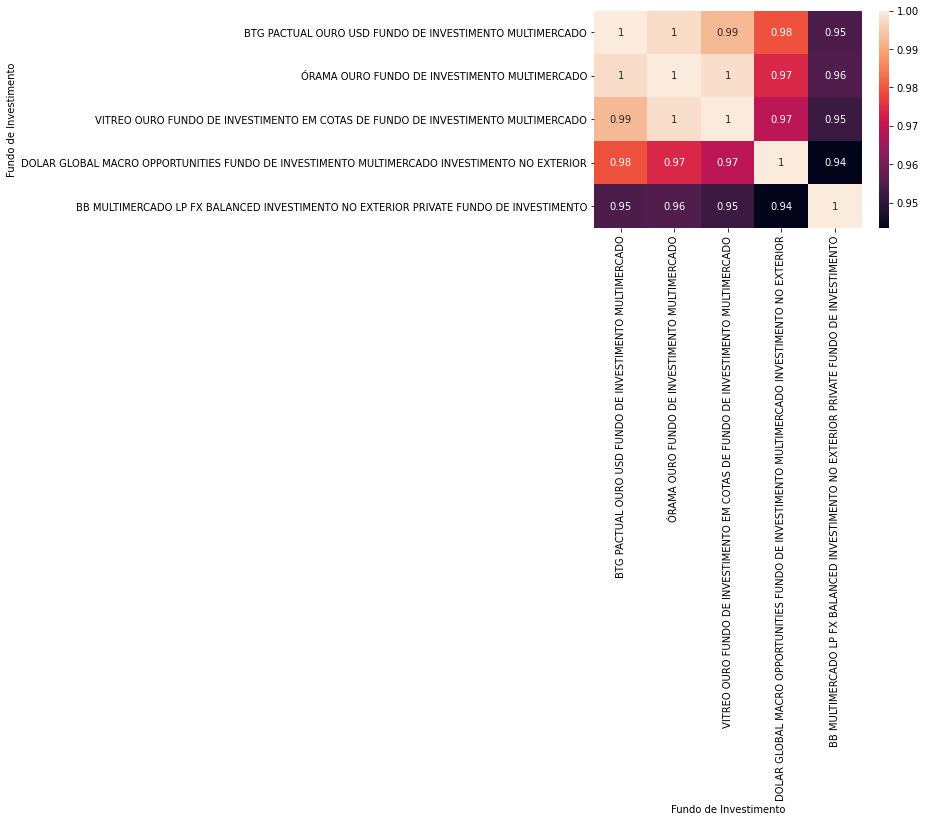

In [74]:
sns.heatmap(cotas.iloc[:, :5].corr(), annot=True);

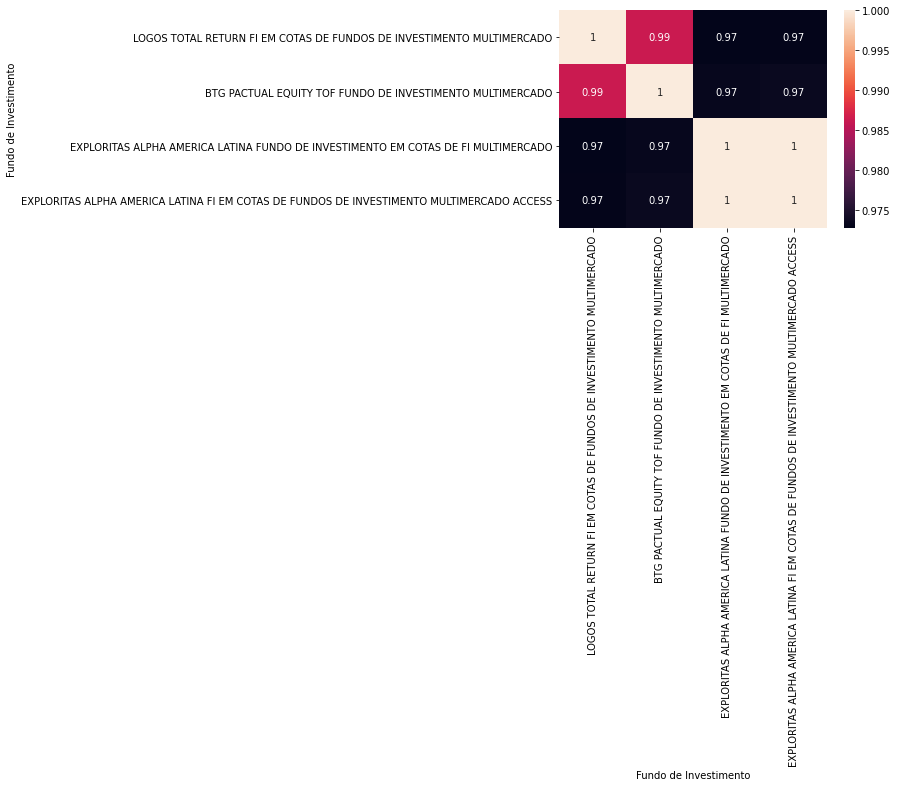

In [75]:
sns.heatmap(cotas.iloc[:, 6:].corr(), annot=True);